 <h3> <center>Performing Sensitivity Analysis with NL4Py         </center></h3>

Start the NetLogoControllerServer

In [1]:
import nl4py
#Start the NetLogoControllerServer
nl4py.startServer("C:/Program Files/NetLogo 6.0.3")

Dependencies installed successfully! 
Start the NetLogoControllerServer using nl4py.startServer()
Shutting down old server instance...
Server started.


Define what a simulation is. In this experiment, a simulation run is initialized with a parameter configuration, resets the model and runs it for 100 ticks. We perform the sensitivity analysis on the sheep, wolves, and grass version of the Wolf Sheep Predation model. We track the sheep and wolf populations over time as model output.

In [2]:
def simulate(workspace_,parameters):
    workspace_.command("stop")
    for i, name in enumerate(problem['names']):
        if name == 'random-seed':
            workspace_.command('random-seed {}'.format(parameters[i]))
        else:
            workspace_.command('set {0} {1}'.format(name, parameters[i]))
    workspace_.command('set model-version "sheep-wolves-grass"')
    workspace_.command('setup')
    workspace_.scheduleReportersAndRun(["ticks",'count sheep','count wolves'], 0,1,100,"go")    

Since the number of runs required would most likely far exceed the number of cores available, we define a function that makes sure we only run a number parallel NetLogoHeadlessWorkspaces equal to the number of cores on the machine for optimal performance.

We then iterate through the entire set of parameter configurations sampled from the product space and execute simulate(...) accordingly. The simulation output is obtained and aggregated into a final metric. 

In this experiment, we target <b>population equilibrium</b> (<a href="http://science.sciencemag.org/content/186/4164/645">May, 1974</a>). To quantify equilibrium we find the <b>population_stability</b> as the reciprocal of the derivatives of both populations over simulation time. The resulting <b>population_stabilities</b> are passed through a heavyside function to give a score of zero if populations that are equal to 0, (equilibria can exist both at extinction in addition to populations > 0). The <b>population_stability_total</b> is found as the mean <b>population_stability</b> over time between both species. Finally, the <b>aggregate_metric</b> scoring the simulation run is calculated as the mean <b>population_stability_total</b> over time.

In [3]:
import pandas as pd
import numpy as np
def runForParameters(experiment):
    runsDone = 0
    runsStarted = 0
    runsNeeded = experiment.shape[0]
    aggregate_metrics = []
    #Find the number of cores on this machine so we can create the optimal number of parallel workspaces
    import multiprocessing
    parallel_workspace_count = multiprocessing.cpu_count()
    #Delete any existing headlessworkspaces
    nl4py.deleteAllHeadlessWorkspaces()
    #Create the optimal number of headlessworkspaces, open the model on them, and run the first set of simulations
    for i in range(0,parallel_workspace_count):
        workspace = nl4py.newNetLogoHeadlessWorkspace()
        workspace.openModel('Wolf Sheep Predation.nlogo')
        simulate(workspace,experiment[runsStarted])
        runsStarted = runsStarted + 1
    #Track the simulations for completion on the headlessworkspaces
    #If simulations are done, process the results
    #Repeat this until the required number of iterations have been complete, for all parameter configurations
    while (runsDone < runsNeeded):
        for workspace in nl4py.getAllHeadlessWorkspaces():
            newResults = workspace.getScheduledReporterResults()
            if len(newResults) > 0:
                ###Process simulation results###
                df = pd.DataFrame(newResults)
                sheep_pop = pd.to_numeric(df.iloc[:,1])
                wolves_pop = pd.to_numeric(df.iloc[:,2])
                #since time is in simulation ticks, this is the absolute rate of change of sheep population.
                dsheep_dt = sheep_pop.diff().abs()
                #since time is in simulation ticks, this is the absolute rate of change of wolf population.
                dwolves_dt = wolves_pop.diff().abs()   
                #Find population stabilities over time for species as reciprocal of derivatives multiplied by
                # a heavyside function ensuring extinction is scored at 0.
                population_stability_sheep = np.divide(1,(dsheep_dt + 0.000001)).mul(np.where(sheep_pop==0,0,1))
                population_stability_wolves = np.divide(1,(dwolves_dt + 0.000001)).mul(np.where(wolves_pop==0,0,1))
                #Find total population stability over time as the mean of population stabilities for both species.
                population_stability_total = (population_stability_sheep + population_stability_wolves) / 2
                #the aggregate metric is the mean, total population stability over time
                aggregate_metric = population_stability_total.sum()/len(population_stability_total)
                aggregate_metrics.append(aggregate_metric)
                ###Done processing simulation results###
                runsDone = runsDone + 1
                if runsStarted < runsNeeded:
                    simulate(workspace,experiment[runsStarted])
                    runsStarted = runsStarted + 1
    for workspace in nl4py.getAllHeadlessWorkspaces():
        workspace.command("stop")
    nl4py.deleteAllHeadlessWorkspaces()
    
    return aggregate_metrics

Next, we use NL4Py to read in the parameters from the NetLogo model's interface and populate the problem space, required by SALib for sensitivity analysis, with both the names and ranges, automatically. 

In [4]:
ws = nl4py.newNetLogoHeadlessWorkspace()
ws.openModel("./Wolf Sheep Predation.nlogo")
#Read in the parameter info with NL4Py functions and generate a SALib problem
problem = { 
  'num_vars': 8,
  'names': ['random-seed'],
  'bounds': [[1, 100000]]
}
problem['names'].extend(ws.getParamNames()[:-2])
problem['bounds'].extend( [item[0::2] for item in ws.getParamRanges()[:-2]])
print(problem)

{'bounds': [[1, 100000], [0.0, 250.0], [0.0, 50.0], [1.0, 20.0], [0.0, 250.0], [0.0, 100.0], [0.0, 20.0], [0.0, 100.0]], 'num_vars': 8, 'names': ['random-seed', u'initial-number-sheep', u'sheep-gain-from-food', u'sheep-reproduce', u'initial-number-wolves', u'wolf-gain-from-food', u'wolf-reproduce', u'grass-regrowth-time']}


The simulation experiment is now defined. We can now run sensitivity analysis using techniques of our choice.
We choose to use <a href="http://salib.readthedocs.io/en/latest/">SALib</a>. 

First, we perform Sobol's sensitivity analysis using Saltelli's sampling sequence technique. <a href="https://www.sciencedirect.com/science/article/pii/S0378475400002706">(Sobol 2001)</a>,<a href="https://www.sciencedirect.com/science/article/pii/S0010465502002801">(Saltelli 2002)</a>,<a href="https://www.sciencedirect.com/science/article/pii/S0010465509003087">(Saltelli et al. 2010)</a>

In [ ]:
from SALib.sample import saltelli
from SALib.analyze import sobol
param_values_sobol = saltelli.sample(problem, 1000)
Y = np.array(runForParameters(param_values_sobol))
Si_Sobol = sobol.analyze(problem, Y, print_to_console=True, parallel=True, n_processors=multiprocessing.cpu_count())

Plot the first order Sobol sensitivity indices

In [ ]:
#Get the absolute values of the first order sobol sensitivity indices
sobol_s1_abs = np.abs(Si_Sobol["S1"])
from matplotlib import pyplot
import matplotlib as mpl
mpl.rcParams['font.size'] = 30.0
#The residual of the first order sensitivity indicies represents the sensitivity caused by 
# higher order interactions of the parameters
S1_and_interactions_sobol = np.append(sobol_s1_abs,(1 - sobol_s1_abs.sum()))
labels = np.append(problem['names'],'Interactions')
print(S1_and_interactions_sobol)
print(labels)
fig = pyplot.figure(figsize=[15, 15])
ax = fig.add_subplot(111)
plot = ax.pie(S1_and_interactions_sobol, labels = labels, labeldistance=1.1, startangle=10, radius=0.5)
fig.savefig('SobolWSPS1.png')

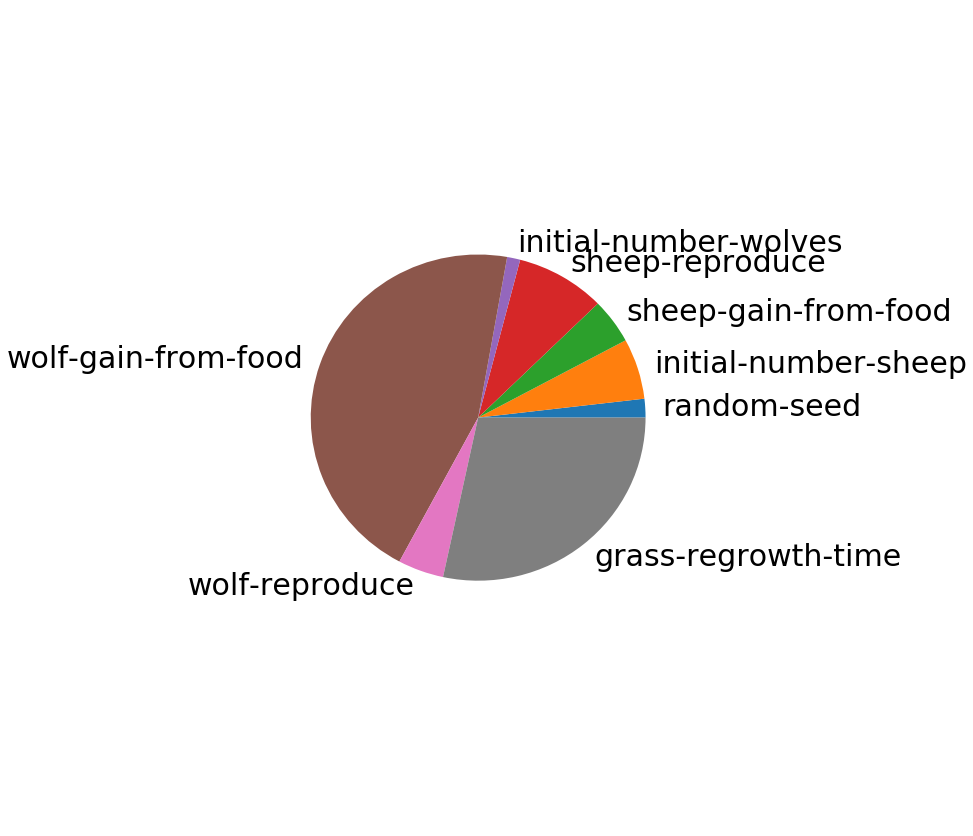

In [134]:
fig = pyplot.figure(figsize=[15, 15])
ax = fig.add_subplot(111)
plot = ax.pie(Si_Sobol["ST"], labels = labels[0:8], labeldistance=1.1, startangle=0, radius=0.5)
fig.savefig('SobolWSPST.png')

In [26]:
from SALib.analyze import fast
from SALib.sample import fast_sampler
nl4py.deleteAllHeadlessWorkspaces()
param_values_fast = fast_sampler.sample(problem, 1000)
Y = np.array(runForParameters(param_values_fast))
Si_FAST = fast.analyze(problem, Y, print_to_console=True)

Parameter First Total
random-seed 0.001059 0.463228
initial-number-sheep 0.010898 0.460543
sheep-gain-from-food 0.006270 0.411794
sheep-reproduce 0.005258 0.542986
initial-number-wolves 0.010222 0.526413
wolf-gain-from-food 0.170540 0.894915
wolf-reproduce 0.004710 0.531344
grass-regrowth-time 0.005400 0.695958


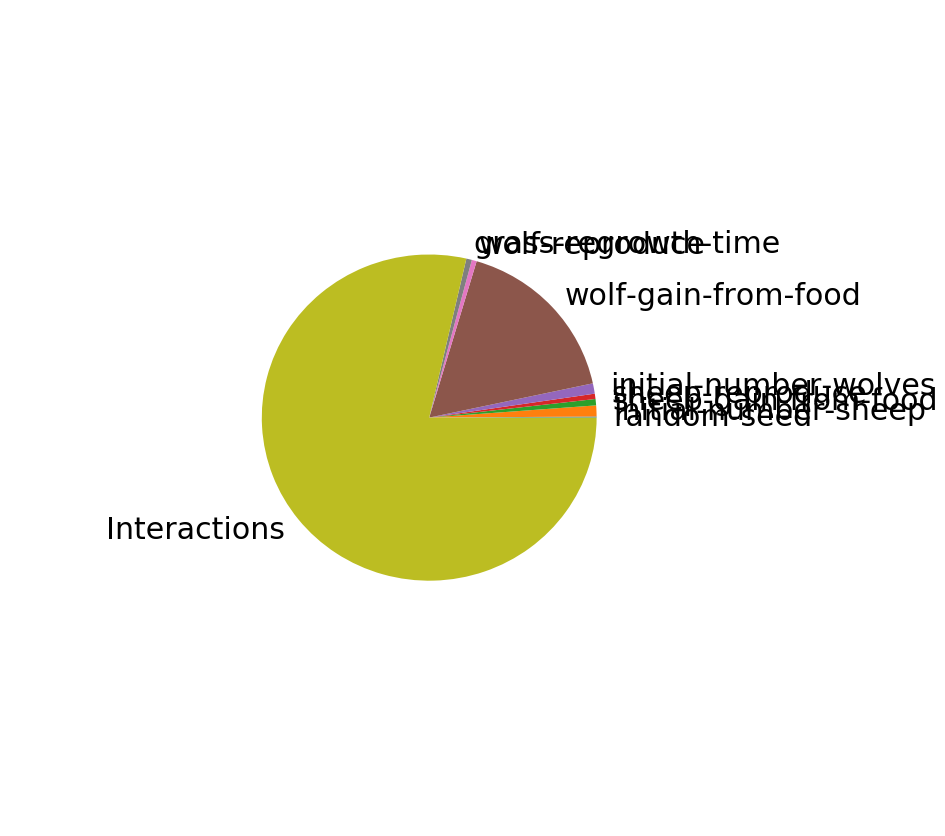

In [135]:
S1_and_interactions_fast = np.append(np.array(Si_FAST["S1"]),(1 - np.array(Si_FAST["S1"]).sum()))

fig = pyplot.figure(figsize=[15, 15])
ax = fig.add_subplot(111)
plot = ax.pie(S1_and_interactions_fast,labels = labels, labeldistance=1.1, startangle=0, radius=0.5)
fig.savefig('FASTWSPS1.png')

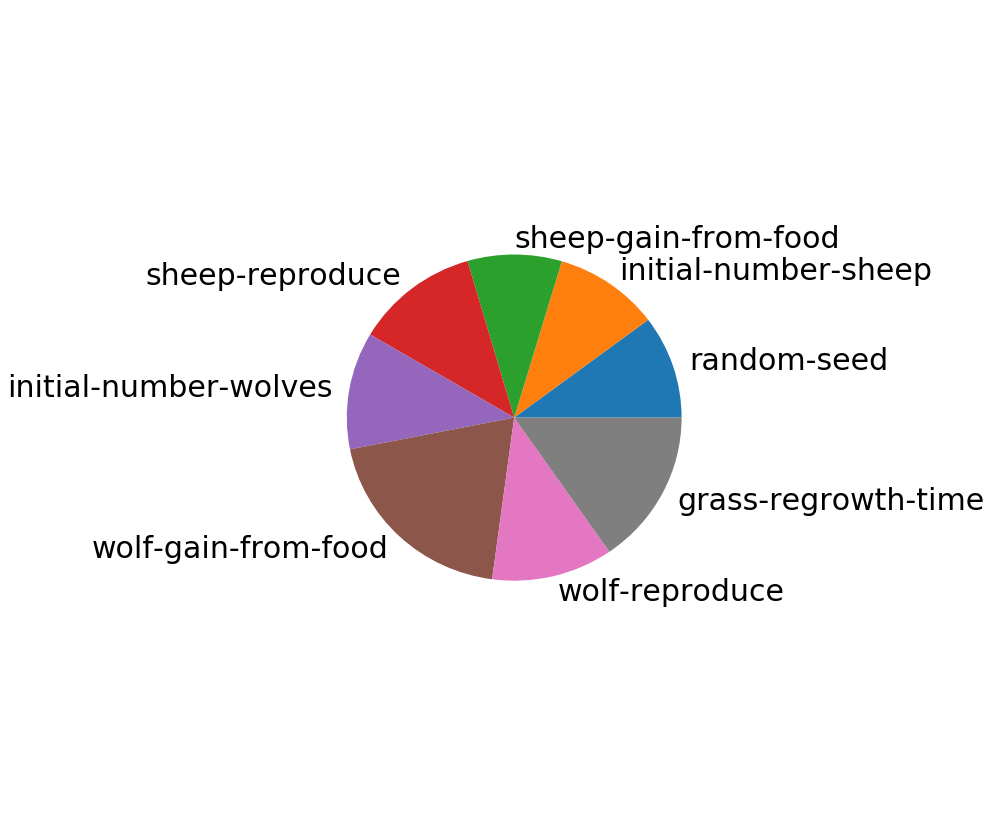

In [136]:
fig = pyplot.figure(figsize=[15, 15])
ax = fig.add_subplot(111)
plot = ax.pie(Si_FAST["ST"], labels = labels[0:8], labeldistance=1.1, startangle=0, radius=0.5)
fig.savefig('FASTWSPST.png')

8